In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm 

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset
from HiCMap import HiCMap
from ConfigDataset import ConfigDataset
from OrigamiTransform import OrigamiTransform
origami_transform = OrigamiTransform()
sys.path.insert(2,'../diffusion/')
from classifier_free_guidance_greg import Unet, GaussianDiffusion

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /state/partition1/slurm_tmp/24959501.0.0/tmp30f5ixyu
INFO:torch.distributed.nn.jit.instantiator:Writing /state/partition1/slurm_tmp/24959501.0.0/tmp30f5ixyu/_remote_module_non_scriptable.py
2024-02-05 14:45:17.485531: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
chrom = '1'
region_idx = None #None if no restriction
nbeads = 128 #64
resolution = 20_000
embeddings_nbeads = 65 
#sample_directory = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_final_embeddings/'
sample_directory = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_64_no_embed_reduction/'
mean_dist_fp = '../../data/mean_dists.pt'
'''
cond_scales = 2.#5.#.4 #[k/10 for k in range(10)]#[0.5,1.,2.,3.,4.,5.]
rescaled_phis = 10#5.#.4 #[k/10 for k in range(10)]
milestones = 120#240 
'''
'''
cond_scales = .9
rescaled_phis = .9
milestones = 120
'''
cond_scales = None#.4
rescaled_phis = None#.4
milestones = None#240
region_idxs = None 
r_c = 1.6
sigma = 6

In [32]:
chroms = [chrom]

In [33]:
config_ds = ConfigDataset(
    filepath='../../data/processed_data.hdf5',
    segment_length=nbeads,
    allow_overlap=False,#True,
    chroms = chroms,
    replicates=[1]
)

In [25]:
exp_hic = HiCDataset()

In [26]:
#emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings/chrom_{chrom}.tar.gz'
emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings_{embeddings_nbeads}/chrom_{chrom}.tar.gz'
embeddings_dict = {}
for chrom in chroms: 
    embeddings_dict[chrom] = pd.read_pickle(emb_fp(chrom))

In [72]:
'''
def get_tan_coords(region_idx=region_idx,embeddings=embeddings_dict[chroms[0]]):
    _,chrom,start_idx = embeddings.index[region_idx]
    _,coords = config_ds.fetch_specific_coords(chrom,start_idx)
    return coords
''';

#### Build the distance map relationships for Longzhi Tan structures

In [148]:
def get_all_tan_structures(nbeads=nbeads,config_ds=config_ds,embeddings_dict=embeddings_dict):

    configs = []
    N = 20_000 * nbeads
    for chrom in embeddings_dict:
        embeddings = embeddings_dict[chrom]
        start_idx1 = -N
        
        for _,_,start_idx in embeddings.index:
            if start_idx - start_idx1 >= N:
                _,coords = config_ds.fetch_specific_coords(chrom,start_idx)
                if coords is not None:
                    configs.append(coords)
                    start_idx1 = start_idx
            
    return torch.cat(configs,dim=0)
    

In [149]:
tan_configs = get_all_tan_structures()

In [150]:
all_dists = torch.cdist(tan_configs,tan_configs)
tan_dists = {}
for sep in range(1,nbeads):
    tan_dists[sep] = all_dists[...,range(nbeads-sep),range(sep,nbeads)].flatten()
    tan_dists[sep] = tan_dists[sep][tan_dists[sep].isfinite()]

In [156]:
all_dists = torch.cdist(tan_configs,tan_configs)
tan_dists1 = {}
for sep in range(1,nbeads):
    tan_dists1[sep] = all_dists[...,range(nbeads-sep),range(sep,nbeads)]#.flatten()
    tan_dists1[sep] = tan_dists1[sep]

#### Get the experimental Hi-C data

In [109]:
chrom1_exp = exp_hic.fetch(chrom='1')

In [110]:
exp_data = chrom1_exp.prob_map
n = exp_data.shape[-1]
exp_probs = {}
for sep in range(1,nbeads):
    exp_probs[sep] = exp_data[range(n-sep),range(sep,n)]
    exp_probs[sep] = exp_probs[sep][exp_probs[sep].isfinite()]

Normalize to the nearest neighbor probs

In [111]:
norm_factor = exp_probs[1].mean()
for sep in range(1,nbeads):
    exp_probs[sep]/= norm_factor

#### Compare the results! 

In [182]:
def dist_to_prob(r,r_c,sigma):
    r = r.clone()
    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**3#4
    
    return r #HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)
    

In [165]:
def test_pairwise(separation,r_c,sigma,tan_dists=tan_dists1):

    probs = dist_to_prob(tan_dists[separation],r_c,sigma)
    n_chunks = probs.shape[0] // 2
    
    probs_final = torch.empty_like(probs[:n_chunks,...])
    
    probs = probs.chunk(n_chunks,dim=0)

    for i,p in enumerate(probs): 
        probs_final[i,...] = 1 - (1-p[0,...])*(1-p[1,...])

    return probs_final

In [190]:
def test_pairwise_threshold(separation,r_c,sigma,tan_dists=tan_dists1):

    #probs = dist_to_prob(tan_dists[separation],r_c,sigma)
    probs = (tan_dists[separation] < r_c).float()
    n_chunks = probs.shape[0] // 2
    
    probs_final = torch.empty_like(probs[:n_chunks,...])
    
    probs = probs.chunk(n_chunks,dim=0)

    for i,p in enumerate(probs): 
        probs_final[i,...] = p.max(0)[0]#1 - (1-p[0,...])*(1-p[1,...])

    return probs_final.mean(0)

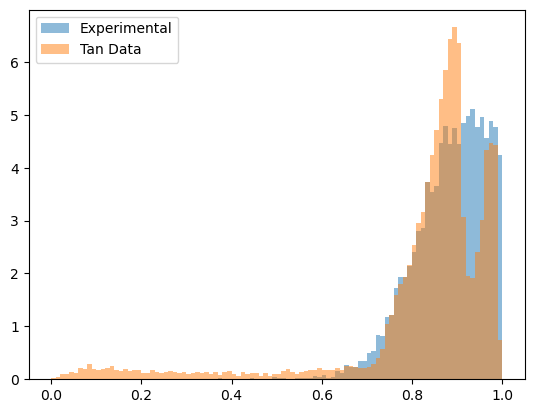

In [167]:
separation = 1
r_c = 2#1.75
sigma = 1.3#3.5
nbins = 100

db = 1/nbins
bins = torch.arange(0,1+db/2,db)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(exp_probs[separation].cpu().numpy(),bins=bins,label='Experimental',alpha=.5,density=True)
tan_probs = dist_to_prob(tan_dists[separation],r_c,sigma).cpu().numpy()
ax.hist(tan_probs,bins=bins,label='Tan Data',alpha=.5,density=True)
ax.legend()

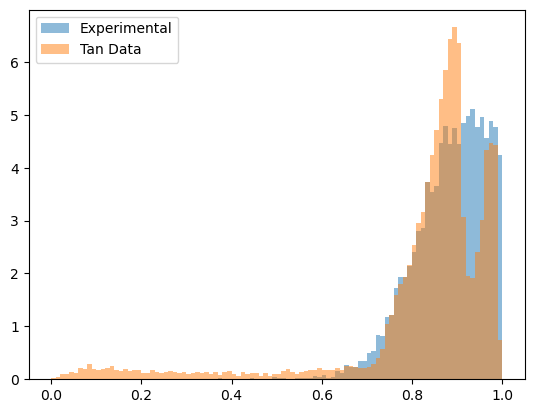

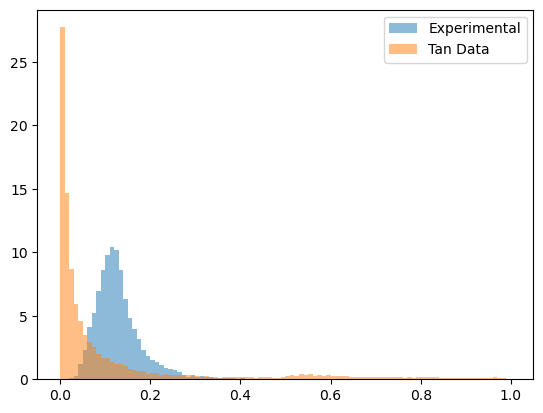

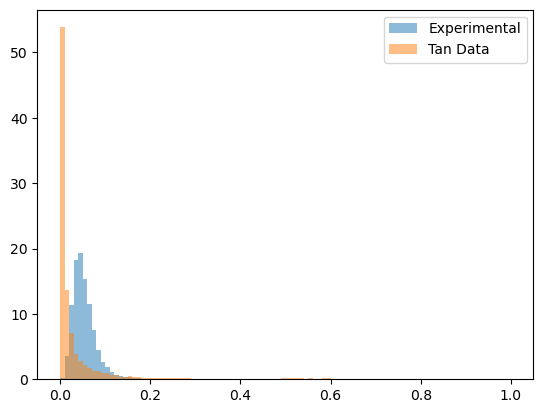

In [143]:
r_c = 2#1.75
sigma = 1.3#3.5
nbins = 100

db = 1/nbins
bins = torch.arange(0,1+db/2,db)

for separation in [1,10,25]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(exp_probs[separation].cpu().numpy(),bins=bins,label='Experimental',alpha=.5,density=True)
    tan_probs = dist_to_prob(tan_dists[separation],r_c,sigma).cpu().numpy()
    ax.hist(tan_probs,bins=bins,label='Tan Data',alpha=.5,density=True)
    ax.legend()

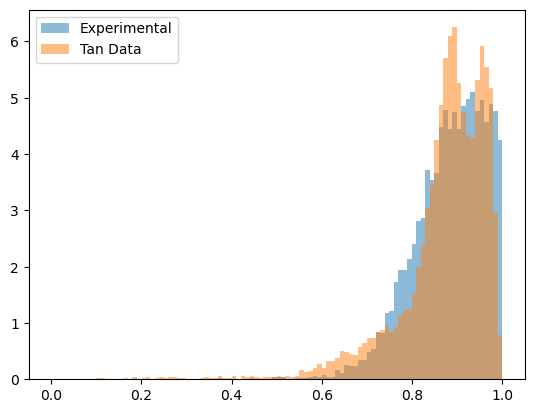

In [192]:
separation = 1
r_c = 1.6#1.75
sigma = 1#3.5
nbins = 100

db = 1/nbins
bins = torch.arange(0,1+db/2,db)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(exp_probs[separation].cpu().numpy(),bins=bins,label='Experimental',alpha=.5,density=True)
#tan_probs = dist_to_prob(tan_dists[separation],r_c,sigma).cpu().numpy()
tan_probs = test_pairwise(separation,r_c,sigma).flatten().cpu().numpy()
ax.hist(tan_probs,bins=bins,label='Tan Data',alpha=.5,density=True)
ax.legend()

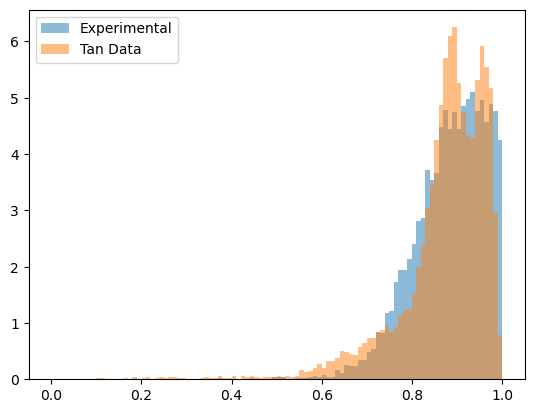

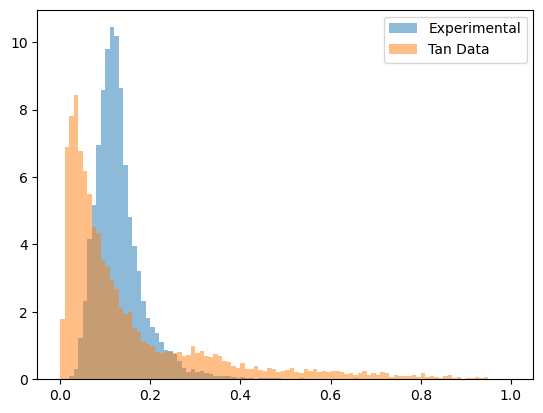

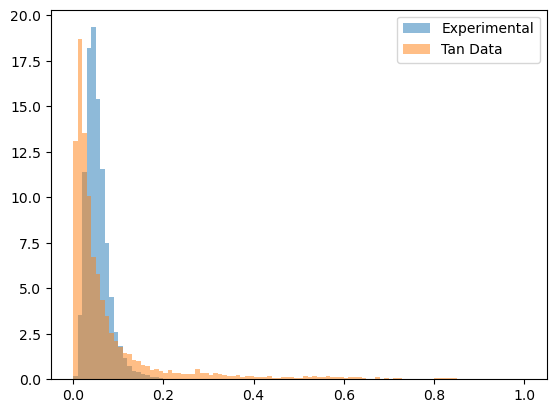

In [183]:
r_c = 1.6#1.75
sigma = 1#3.5
nbins = 100

db = 1/nbins
bins = torch.arange(0,1+db/2,db)

for separation in [1,10,25]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(exp_probs[separation].cpu().numpy(),bins=bins,label='Experimental',alpha=.5,density=True)
    #tan_probs = dist_to_prob(tan_dists[separation],r_c,sigma).cpu().numpy()
    tan_probs = test_pairwise(separation,r_c,sigma).flatten().cpu().numpy()
    ax.hist(tan_probs,bins=bins,label='Tan Data',alpha=.5,density=True)
    ax.legend()

In [188]:
torch.rand(10,10).max(0)

torch.return_types.max(
values=tensor([0.9220, 0.9893, 0.8946, 0.8854, 0.9826, 0.9756, 0.8914, 0.8791, 0.8806,
        0.9662]),
indices=tensor([3, 0, 8, 0, 2, 7, 4, 0, 3, 1]))

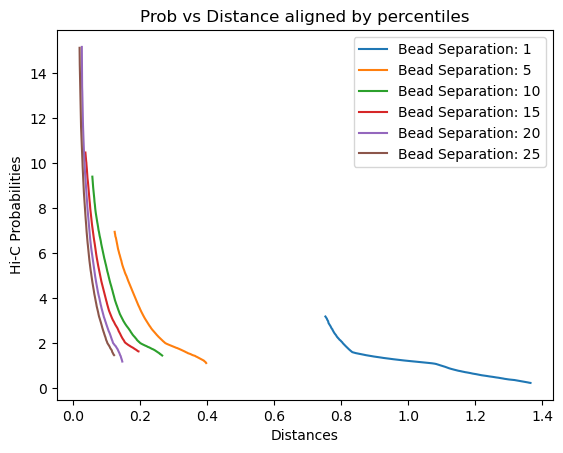

In [232]:
nvals = 1_000
fig = plt.figure()
ax = fig.add_subplot(111)
for separation in [1,5,10,15,20,25]:

    d_percentiles = tan_dists[separation].flatten().sort()[0]
    n = d_percentiles.numel() // nvals
    d_percentiles = d_percentiles[::n]
    n = d_percentiles.numel()
    n_remove = n - nvals
    ii = n_remove//2
    jj = n_remove - ii
    if jj == 0: 
        d_percentiles = d_percentiles[ii:].flip(0).cpu().numpy()
    else:
        d_percentiles = d_percentiles[ii:-jj].flip(0).cpu().numpy()
    
    p_percentiles = exp_probs[separation].flatten().sort()[0]
    n = p_percentiles.numel() // nvals
    p_percentiles = p_percentiles[::n]
    n = p_percentiles.numel()
    n_remove = n - nvals
    ii = n_remove//2
    jj = n_remove - ii
    if jj == 0: 
        p_percentiles = p_percentiles[ii:].cpu().numpy()
    else:
        p_percentiles = p_percentiles[ii:-jj].cpu().numpy()
    
    #ax.plot(d_percentiles,p_percentiles,label=f'Bead Separation: {separation}')
    ax.plot(p_percentiles,d_percentiles,label=f'Bead Separation: {separation}')
ax.set_xlabel('Distances')
ax.set_ylabel('Hi-C Probabilities')
ax.set_title('Prob vs Distance aligned by percentiles')
ax.legend()